In [1]:
import numpy as np
from dataclasses import dataclass
import random 
n=13

@dataclass
class Parameters:
    insulin_plasma_fat: float
    insulin_fat_plasma: float

    V_fat: float

    fattyacids_plasma_fat: float
    fattyacids_fat_plasma: float

    glucose_plasma_fat: float
    glucose_fat_plasma: float

    aminoacids_plasma_fat: float
    aminoacids_fat_plasma: float



    V_plasma: float


    glucose_to_g6p: float
    g6p_to_glucose: float

    CLinsulin: float

    g6p_to_pyruvate: float 
    pyruvate_to_g6p: float


    pyruvate_to_acetylcoa: float 

    acetylcoa_to_fattyacids: float  

    fattyacids_to_acetylcoa: float  
    aminoacids_to_acetylcoa: float   

    fattyacids_to_triglycerides: float
    triglycerides_to_fattyacids: float

    
    

p = Parameters(
    insulin_plasma_fat=1,         
    insulin_fat_plasma=0.1,            
    V_fat=11.0,
    #give or take 1-2 liters. Usually 2-3 liters less on average for women
    # visceral fat is about 10% of total fat volume                       
    
    fattyacids_plasma_fat=2,         
    fattyacids_fat_plasma=0.2,        

    glucose_plasma_fat=1,            
    glucose_fat_plasma=0.1,            

    aminoacids_plasma_fat=1,
    aminoacids_fat_plasma=0.1,

    V_plasma=5.0,                                


    glucose_to_g6p=1,
    g6p_to_glucose=0.1,


    CLinsulin = 1,
    
    g6p_to_pyruvate=1,
    pyruvate_to_g6p=0.1,

    # Acetyl-CoA & TCA
    pyruvate_to_acetylcoa=1,
    
    acetylcoa_to_fattyacids=1,


    # Alternative fuels
    fattyacids_to_acetylcoa=1/8,
    
    aminoacids_to_acetylcoa=1/4,
    

    # Anaerobic respiration
    fattyacids_to_triglycerides=1,
    triglycerides_to_fattyacids=0.1
)

# 0 glucose plasma
# 1 glucose fat
# 2 insulin plasma
# 3 insulin fat
# 4 fattyacids plasma
# 5 fattyacids fat
# 6 aminoacids plasma
# 7 aminoacids fat
# 8 g6p fat
# 9 triglycerides fat
# 10 Pyruvate
# 11 acetylcoa fat
# 12 ROS fat




def fat(t,y,p):
    dydt = np.zeros(n)

    dglucose = glucose(t,y,p)
    dinsulin = insulin(t,y,p)
    dfattyacids = fattyacids(t,y,p)
    daminoacids = aminoacids(t,y,p)
    dg6p = g6p(t,y,p)
    dtriglycerides = triglycerides(t,y,p)
    dpyruvate = pyruvate(t,y,p)
    dacetylcoa = acetylcoa(t,y,p)
    dROS = ROS(t,y,p)
  
    
    dydt = dglucose+dinsulin+dfattyacids+daminoacids+dg6p+dtriglycerides+dpyruvate+dacetylcoa+dROS
    return dydt

def glucose(t, y, p):
    dydt = np.zeros(n)
    dydt[0] = (
        (-p.glucose_plasma_fat * y[0] * p.V_plasma + p.glucose_fat_plasma * y[1] * p.V_fat) / p.V_plasma
    )
    dydt[1] = (
        (p.glucose_plasma_fat * y[0] * p.V_plasma - p.glucose_fat_plasma * y[1] * p.V_fat) / p.V_fat
        -p.glucose_to_g6p * y[1] + p.g6p_to_glucose *y[8]
    )
    return dydt

def insulin(t, y, p):
    dydt = np.zeros(n)
    dydt[2] = ((-p.insulin_plasma_fat * y[2] *p.V_plasma + p.insulin_fat_plasma * y[3] * p.V_fat) / p.V_plasma
               )
    dydt[3] = ((p.insulin_plasma_fat * y[2] *p.V_plasma - p.insulin_fat_plasma * y[3] * p.V_fat) / p.V_fat
               -p.CLinsulin*y[3])
    return dydt

def fattyacids(t, y, p):
    Km=1
    dydt = np.zeros(n)
    dydt[4] = ((-p.fattyacids_plasma_fat * y[4] * p.V_plasma + p.fattyacids_fat_plasma * y[5] * p.V_fat) / p.V_plasma
               )
    dydt[5] = ((p.fattyacids_plasma_fat * y[4] * p.V_plasma - p.fattyacids_fat_plasma * y[5] * p.V_fat) / p.V_fat
               -p.fattyacids_to_acetylcoa * y[5]
               -3*(p.fattyacids_to_triglycerides*p.V_fat*y[5]/(Km+y[5]*p.V_fat))**3 +3*p.triglycerides_to_fattyacids*y[9]
               + p.acetylcoa_to_fattyacids *y[11])
    
    return dydt



def aminoacids(t, y, p):
    dydt = np.zeros(n)
    dydt[6] = ((-p.aminoacids_plasma_fat * y[6] * p.V_plasma + p.aminoacids_fat_plasma * y[7] * p.V_fat) / p.V_plasma
               )
    dydt[7] = ((p.aminoacids_plasma_fat * y[6] * p.V_plasma - p.aminoacids_fat_plasma * y[7] * p.V_fat) / p.V_fat
               - p.aminoacids_to_acetylcoa * y[7])
    return dydt

def g6p(t,y,p):
    dydt = np.zeros(n)
    
    dydt[8] = (
        p.glucose_to_g6p * y[1] - p.g6p_to_glucose *y[8]
        -p.g6p_to_pyruvate * y[8] + p.pyruvate_to_g6p *y[10]**2 
    )
    return dydt

def triglycerides(t,y,p):
    dydt = np.zeros(n)

    Km= 1
    
    dydt[9] = (
        (p.fattyacids_to_triglycerides*p.V_fat*y[5]/(Km+y[5]*p.V_fat))**3 -p.triglycerides_to_fattyacids*y[9]
    )
    return dydt

def pyruvate(t,y,p):
    dydt = np.zeros(n)
    dydt[10] =  (2* p.g6p_to_pyruvate * y[8] - 2*p.pyruvate_to_g6p *y[10]**2 
                - p.pyruvate_to_acetylcoa * y[10] 
                )
    return dydt

def acetylcoa(t,y,p):
    dydt = np.zeros(n)
    dydt[11] = (p.pyruvate_to_acetylcoa * y[10] + 8*p.fattyacids_to_acetylcoa * y[5]  + p.aminoacids_to_acetylcoa * y[7]
                - 8*p.acetylcoa_to_fattyacids *y[11])
    return dydt
#assume 16 carbon chain (palmitic acid)

def ROS(t,y,p):
    #might include a randomness aspect here. not sure what the probability will be
    ROSpercent = 0.01
    Km=1
    #https://www.ncbi.nlm.nih.gov/books/NBK500351/
    #1-2% of molecular oxygen is converted to superoxide owing to electron elak
    dydt = np.zeros(n)
    dydt[12] = ROSpercent*(
                +p.fattyacids_to_acetylcoa * y[5] + p.aminoacids_to_acetylcoa * y[7]
                +3*(p.fattyacids_to_triglycerides*p.V_fat*y[5]/(Km+y[5]*p.V_fat))**3 +3*p.triglycerides_to_fattyacids*y[9]
                + 8*p.acetylcoa_to_fattyacids *y[11])

    return dydt

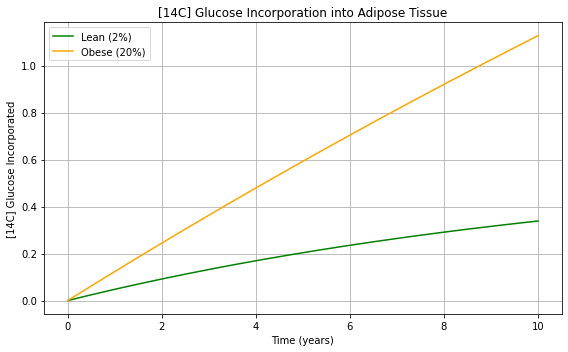

In [3]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

n = 14  # number of state variables

@dataclass
class Parameters:
    V_fat: float
    V_plasma: float
    glucose_plasma_fat_base: float
    glucose_fat_plasma: float
    glucose_incorp_frac: float
    base_perfusion_per_l_fat: float  # glucose uptake per L fat
    glucose_to_g6p: float
    g6p_to_glucose: float

def glucose(t, y, p):
    dydt = np.zeros(n)

    # Calculate actual glucose uptake rate per L fat tissue
    uptake_rate_per_fat_volume = p.base_perfusion_per_l_fat / p.V_fat
    flux_to_fat = uptake_rate_per_fat_volume * p.glucose_plasma_fat_base * y[0] * p.V_plasma
    flux_from_fat = p.glucose_fat_plasma * y[1] * p.V_fat

    dydt[0] = (-flux_to_fat + flux_from_fat) / p.V_plasma
    dydt[1] = (flux_to_fat - flux_from_fat) / p.V_fat - p.glucose_to_g6p * y[1] + p.g6p_to_glucose * y[8]
    dydt[13] = p.glucose_incorp_frac * flux_to_fat  # [14C] incorporation

    return dydt

def fat(t, y, p):
    dydt = np.zeros(n)
    dydt += glucose(t, y, p)
    return dydt

def simulate(p, label):
    y0 = np.zeros(n)
    y0[0] = 5.5  # glucose plasma
    y0[1] = 0.0  # glucose in fat
    y0[13] = 0.0  # [14C] glucose accumulation

    t_span = (0, 10)  # years
    t_eval = np.linspace(*t_span, 200)

    sol = solve_ivp(lambda t, y: fat(t, y, p), t_span, y0, t_eval=t_eval, method='LSODA')
    return sol.t, sol.y[13], label

# Lean individual parameters
p_lean = Parameters(
    V_fat=11.0,
    V_plasma=5.0,
    glucose_plasma_fat_base=1.0,
    glucose_fat_plasma=0.1,
    glucose_incorp_frac=0.02,
    base_perfusion_per_l_fat=1.0,  # baseline: 1.0 uptake per L fat
    glucose_to_g6p=1.0,
    g6p_to_glucose=0.1
)

# Obese individual: same plasma properties, but more fat and lower perfusion per unit tissue
p_obese = Parameters(
    V_fat=22.0,
    V_plasma=5.0,
    glucose_plasma_fat_base=1.0,
    glucose_fat_plasma=0.1,
    glucose_incorp_frac=0.2,
    base_perfusion_per_l_fat=0.5,  # 50% reduction in uptake per unit fat
    glucose_to_g6p=1.0,
    g6p_to_glucose=0.1
)

# Run simulations
t1, y1, label1 = simulate(p_lean, 'Lean (2%)')
t2, y2, label2 = simulate(p_obese, 'Obese (20%)')

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(t1, y1, label='Lean (2%)', color='green')
plt.plot(t2, y2, label='Obese (20%)', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('[14C] Glucose Incorporated')
plt.title('[14C] Glucose Incorporation into Adipose Tissue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
